# Model selection using GpABC

## Problem formulation

This notebook illustrates how to perform model selection using the algorithm described in (Toni et al, 2009). The example here is adapted from the SIR (susceptible-infected-recovered) model in Section 3.3 of the paper. The code to produce the result in the paper is available at the GitHub of the ABCSysBio Python package that accompanies the paper (https://github.com/jamesscottbrown/abc-sysbio/blob/master/examples/SBML/Example1/SIR.ipynb).

The example gives two models that describe the evolution of the number of of susceptible ($S$), infected ($I$) and recovered ($R$) individuals in a population (the number of dead individuals is not included in the model).

There are two possible models, both of which are described below. Given some observed data on the number of individuals in each disease state over time we wish to determine which of the two models is better supported by these data.

### Model 1

A basic SIR model assumes that each individual can be infected once and is then able to infect other individuals immediately. 

The model is given by

\begin{align}
    \dot{S} &= \alpha - \gamma S I - d S, \\
    \dot{I} &= \gamma S I - v I - d I, \\
    \dot{R} &= v I - d R \, ,
\end{align}

where the notation $\dot{x}$ denotes $\text{d}x/\text{d}t$.

The paramters of this model are the birth rate $\alpha$, the infection rate $\gamma$, the recovery rate $v$ and the death rate $d$. Note that the death rate is constant for all three disease states.

### Model 2

A slightly more sophisticated model includes a time delay between an individual becoming infected and being able to infect others by introducing an additional latent state ($L$). This model is given by

\begin{align}
    \dot{S} &= \alpha - \gamma S I - d S , \\
    \dot{L} &= \gamma S I - \delta L - d L , \\
    \dot{I} &= \delta L - v I - d I , \\
    \dot{R} &= v I - d R \, ,
\end{align}

where $\delta$ is the transition rate from latent to infected.

## Model selection algorithm

The ABC SMC algorithm for model selection is available in full in the paper by Toni et al (see references for link). If using full model simulations the algorithm takes the following inputs:

* a prior over the models (the default in GpABC is a discrete uniform prior),
* a schedule of thresholds for each ABC run (the first is rejection ABC and the subsequent runs are ABC SMC),
* parameter priors for each candidate model,
* a maximum number of accepted particles per population, and
* a maximum number of iterations per population (default 1000).

As this is an ABC algorithm observed (reference) data, a distance metric and summary statistic must also be defined. As for other GpABC functions euclidean distance is the default distance metric. 

The psuedocode of the model selection algorithm is 

* Initialise thresholds $\varepsilon_1,...,\varepsilon_T$ for $T$ populations

* Initialise population index $t=1$
  
* While $t<=T$

    * Initialise particle indicator $i=1$

    * Initialise number of accepted particles for each of the $M$ models $A_1,...,A_M=0,...,0$

    * While $\sum_m A_m < $ max no. of particles per population and $i<$ max no. of iterations per population

        * Sample model $m$ from the model prior

            * If t=1

                 * Perform rejection ABC for model $m$ using a single particle using threshold $\varepsilon_t$
                 * If particle is accepted
                     * $A_m = A_m + 1$
            * Else

                * Perform ABC SMC for model $m$ with a single particle using threshold $\varepsilon_t$
                * If particle is accepted
                     * $A_m = A_m + 1$
            
        * $i = i + 1$
            
    * $t=t+1$
        
           
    
Note that for model selection the number of accepted particles applies across all the models, with the model accepting the maximum number of particles in the final population being the one that is best supported by the data.

## Computation in GpABC

### Preamble

The code below loads the required packages and prepares the observed data into the correct format (this is a 2D array with size (number of trajectories, number of time points).

The observed data contains information the number of susceptible, infected and recovered individuals at 13 time points.

In [2]:
# Load required packages
using GpABC, DifferentialEquations, Distributions, Distances, Plots

In [13]:
#
# Experimental data - from ABCSysBio example at
# https://github.com/jamesscottbrown/abc-sysbio/blob/master/examples/SBML/Example1/SIR.ipynb
#
times = [0.0, 0.6, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
data = [[ 20.     ,  10.     ,   0.     ],
       [  0.12313,  13.16813,   9.42344],
       [  0.12102,   7.17251,  11.18957],
       [  0.09898,   2.36466,  10.0365 ],
       [  0.37887,   0.92019,   6.87117],
       [  1.00661,   0.61958,   4.44955],
       [  1.20135,   0.17449,   3.01271],
       [  1.46433,   0.28039,   1.76431],
       [  1.37789,   0.0985 ,   1.28868],
       [  1.57073,   0.03343,   0.81813],
       [  1.4647 ,   0.28544,   0.52111],
       [  1.24719,   0.10138,   0.22746],
       [  1.56065,   0.21671,   0.19627]]

data = hcat(data...); #  To give correct size

3×13 Array{Float64,2}:
 20.0   0.12313   0.12102   0.09898  …  1.57073  1.4647   1.24719  1.56065
 10.0  13.1681    7.17251   2.36466     0.03343  0.28544  0.10138  0.21671
  0.0   9.42344  11.1896   10.0365      0.81813  0.52111  0.22746  0.19627

Next, we define the models. As in other GpABC functions, the model is represented using a function that takes parameters as an argument and returns trajectories that are the solution to the differential equation system. This is called the `simulator_function`. The solution shuuld have the same shape as the reference data, which is (number of trajectories, number of time points).

This means that for the second model, which has 4 states, we need to modify the `simulator_function` in order to ignore the solution for the latent state $L$ as we have no reference data for that trajectory. 

We also need to define different initial conditions for the two models as the first model has 3 states and the second has 4.

In [14]:
# Need initial conditions for each model since they have different numbers of states
ic1 = [20.0, 10.0, 0.0]
ic2 = [20.0, 0.0, 10.0, 0.0]
ics = [ic1, ic2]

# Define a simulator function for each model. Each function returns the solution of the model
# as a 2D array for some parameter values. The appropriate ODE is solved at the same time 
# points as the observed data
function simulator1(params::Array{Float64,1})
    
    # p = (alpha, gamma, d, v)
    # x = (S, I, R)
    function model1(dx, x, p, t)
        dx[1] = p[1] - p[2]*x[1]*x[2] - p[3]*x[1] # dS/dt = alpha - gamma*S*I - d*S
        dx[2] = p[3]*x[1]*x[2] - p[4]*x[2] - p[3]*x[2] # dI/dt = gamma*S*I - v*I - d*I
        dx[3] = p[4]*x[2] - p[3]*x[3] # dR/dt = v*I - d*R
    end
    
    return(Array{Float64,2}(
        solve(ODEProblem(model1, ics[1], (times[1], times[end]), params),
                saveat=times, force_dtmin=true)))
end

function simulator2(params::Array{Float64,1})

    # p = (alpha, gamma, d, v, delta)
    # x = (S, L, I, R)
    function model2(dx, x, p, t)
        dx[1] = p[1] - p[2]*x[1]*x[3] - p[3]*x[1] # dS/dt = alpha - gamma*S*I - d*S
        dx[2] = p[2]*x[1]*x[3] - p[5]*x[2] - p[3]*x[2] # dL/dt = gamma*S*I - delta*L - d*L
        dx[3] = p[5]*x[2] - p[4]*x[3] - p[3]*x[3] # dI/dt = delta*L - v*I - d*I
        dx[4] = p[4]*x[3] - p[3]*x[4] # dR/dt = v*I - d*R
    end
    
    # Model2 contains the species L, which is not measured - we remove it from the returned ODE solution
    # so that it can be compared to the reference data "data", which only contains S, I and R
    return(Array{Float64,2}(
        solve(ODEProblem(model2, ics[2], (times[1], times[end]), params),
                saveat=times, force_dtmin=true)))[[1,3,4],:]
end;

We also need a set of priors for each model, as well as a summary statistic and threshold schedule. We will compare the full model solution with the data, which is the "keep_all" summary statistic. The model prior will be the default discrete uniform prior with span 2 (as there are two models).

In [11]:
#
# Priors and initial conditions - these are model-specfic as each model can 
# have different numbers of parameters/species
#
priors1 = [Uniform(0.0, 5.0) for i in 1:4]
priors2 = vcat([Uniform(0.0, 5.0) for i in 1:4], Uniform(0.0, 10.0))
priors3 = vcat([Uniform(0.0, 5.0) for i in 1:4], Uniform(0.0, 10.0))

threshold_schedule = [20, 15, 10, 5, 3, 2.5, 2, 1.7, 1.5]
summary_statistic = "keep_all"
n_particles = 200;

We are now ready to perform the model selection computation. Using simulation:

In [15]:
ms_sim_result = model_selection(data, n_particles, threshold_schedule,
                    [priors1, priors2], summary_statistic,
                    [simulator1, simulator2]);

Simulated model selection
Population 1
Completed 636 iterations, accepting 200 particles in total
Number of accepted parameters: Model 1: 102	Model 2: 98
Population 2
Completed 1244 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 43	Model 2: 157
Population 3
Completed 2672 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 26	Model 2: 174
Population 4
Completed 10000 iterations, accepting 199 particles
Number of accepted parameters: Model 1: 58	Model 2: 141
Population 5


Completed 6805 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 103	Model 2: 97
Population 6
Completed 2016 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 114	Model 2: 86
Population 7
Completed 2997 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 121	Model 2: 79
Population 8
Completed 2569 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 131	Model 2: 69
Population 9
Completed 2359 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 124	Model 2: 76


GpABC.ModelSelectionOutput(2, AbstractArray{Int64,1}[[102, 98], [43, 157], [26, 174], [58, 141], [103, 97], [114, 86], [121, 79], [131, 69], [124, 76]], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], GpABC.ABCSMCOutput[GpABC.SimulatedABCSMCOutput(4, [102, 43, 26, 58, 103, 114, 121, 131, 124], [314, 630, 1266, 5002, 3413, 975, 1511, 1297, 1216], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], AbstractArray{Float64,2}[[1.97679 3.0218 0.822085 4.52954; 3.63252 4.9118 0.926489 1.24524; … ; 2.57722 3.7976 0.921555 0.394585; 4.38758 1.2435 1.03695 1.07276], [3.88156 0.717599 2.29974 1.42784; 3.45816 0.581412 2.38086 0.993614; … ; 0.979137 3.6176 0.219876 2.38112; 0.302822 1.47593 0.165729 2.77229], [0.688579 0.649141 0.433457 2.07786; 1.06955 1.04773 0.558315 1.33296; … ; 0.485986 0.704527 0.782775 1.08581; 1.40055 0.683428 0.601177 1.70745], [0.798118 0.430167 0.381118 1.1037; 1.1834 0.446293 0.473755 1.05734; … ; 0.72336 0.466828 0.412018 1.21561; 1.07364 0.588292 0.549694 0.893952], 

# @recipe f(::Type{MyVec}, myvec::MyVec) = myvec.v
@recipe f(::Type{ModelSelectionOutput, arr)


In [ ]:
@recipe f(::Type{ModelSelectionOutput, mso::ModelSelectionOutput

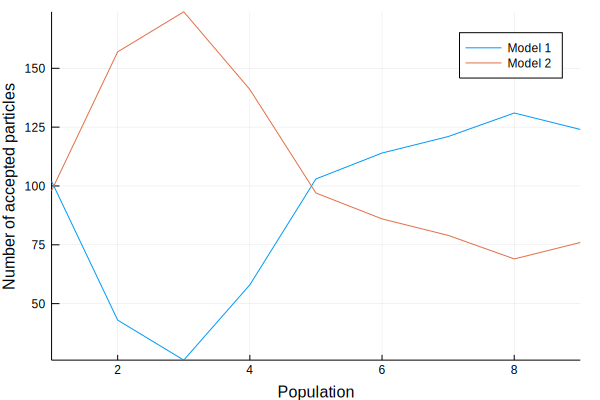

In [61]:
@recipe function modelselection_plotrecipe(::Type{ModelSelectionOutput}, mso::ModelSelectionOutput)
    seriestype := :line
    xlabel --> "Population"
    ylabel --> "Number of accepted particles"
    labels --> [string("Model ", m) for m in 1:mso.M]
    data = [[mso.n_accepted[i][j] for i in 1:size(mso.n_accepted,1)] for j in 1:mso.M]
end
plot(mso)

In [11]:
threshold_schedule = [20, 15, 10, 5, 3, 2.5, 2, 1.7, 1.5]

# Train the emulators
n_design_points = 200
summary_statistic = "keep_all"
distance_metric = euclidean
rt = RepetitiveTraining()
gpkernel = SquaredExponentialArdKernel()

#
# A set of functions that return a trained emulator with a prior sampling function as an argument
#
emulator_trainers = [f(prior_sampler) = GpABC.abc_train_emulator(prior_sampler,
        n_design_points,
        GpABC.build_summary_statistic(summary_statistic)(data),
        sim,
        GpABC.build_summary_statistic(summary_statistic),
        distance_metric)
    for sim in [simulator1, simulator2]]

emulator_settings = [AbcEmulationSettings(n_design_points,
        trainer,
        (x, em) -> gp_regression(x, em)) for trainer in emulator_trainers]

input = EmulatedModelSelectionInput(2, 200, threshold_schedule, modelprior, [priors1, priors2],
    emulator_settings, 100, 1e3)

ms_res = model_selection(input, values)

Emulated model selection
Population 1 - ABC Rejection ϵ = 20.0
Trained emulators
Completed 13 iterations, accepting 200 particles in total
Number of accepted parameters: Model 1: 109	Model 2: 91
Population 2 - ABCSMC ϵ = 15.0
Completed 63 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 68	Model 2: 132
Population 3 - ABCSMC ϵ = 10.0
Completed 509 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 130	Model 2: 70
Population 4 - ABCSMC ϵ = 5.0
Completed 1000 iterations, accepting 89 particles
Number of accepted parameters: Model 1: 45	Model 2: 44
Population 5 - ABCSMC ϵ = 3.0


Completed 1000 iterations, accepting 2 particles
Number of accepted parameters: Model 1: 0	Model 2: 2
Population 6 - ABCSMC ϵ = 2.5


Completed 1000 iterations, accepting 0 particles
Number of accepted parameters: Model 1: 0	Model 2: 0


GpABC.ModelSelectionOutput(2, AbstractArray{Int64,1}[[109, 91], [68, 132], [130, 70], [45, 44], [0, 2], [0, 0]], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5], GpABC.ABCSMCOutput[GpABC.EmulatedABCSMCOutput(4, [109, 68, 130, 45, 0, 0], [316, 0, 0, 0, 0, 0], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5], AbstractArray{Float64,2}[[2.51932 2.18741 0.653133 0.524235; 2.29531 4.29587 2.10961 2.22487; … ; 4.98631 2.81775 1.90816 1.22571; 3.58046 4.00558 2.11353 2.24198], [4.56909 3.34787 0.272535 0.898501; 0.180029 1.05551 2.08302 3.01319; … ; 4.44748 1.14291 2.12755 2.52634; 0.809684 0.928728 1.20651 2.8923], [0.10498 0.750214 1.80512 2.79711; 1.40829 0.43629 0.360746 0.00699345; … ; 3.89482 0.832674 1.97042 0.608193; 2.55265 0.616259 1.02064 0.00521675], [3.91806 0.956576 1.6965 0.442793; 3.35418 0.598678 1.01315 0.109975; … ; 0.0752068 0.750007 1.12923 1.49538; 3.64069 0.79002 0.645045 0.294499], Array{Float64}(0,4), Array{Float64}(0,4)], AbstractArray{Float64,1}[[17.2115, 19.4157, 19.9811, 18.06, 17.7523, 19.840

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##300#301{IJulia.#send_stderr,Timer})() at ./event.jl:430


In [5]:
ms_res.smc_outputs[1]

GpABC.EmulatedABCSMCOutput(4, [0, 0, 0, 0, 0, 0, 0], [669, 0, 0, 0, 0, 0, 0], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0], AbstractArray{Float64,2}[Array{Float64}(0,4), Array{Float64}(0,4), Array{Float64}(0,4), Array{Float64}(0,4), Array{Float64}(0,4), Array{Float64}(0,4), Array{Float64}(0,4)], AbstractArray{Float64,1}[Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]], StatsBase.Weights[Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]], Any[GpABC.GPModel(GpABC.SquaredExponentialArdKernel(GpABC.RbfCovarianceCache([5.89913, 9.99999, -1.17922, 4.31046, 9.31052], [0.0 181.237 … 3.49861 81.2068; 181.237 0.0 … 134.382 19.811; … ; 3.49861 134.382 … 7.10543e-15 50.9994; 81.2068 19.811 … 50.9994 0.0], [1.3302e5 5.87251e-35 … 23131.4 3.09094e-13; 5.87251e-35 1.3302e5 … 8.77475e-25 6.63775; … ; 23131.4 8.77475e-25 … 1.3302e5 1.12083e-6; 3.09094e-13 6.63775 … 1.12083e-6 1.3302e5])), GpABC.HPOptimisationCache([5.89913, 9.99999, -1.17922, 4.31046, 9.3

In [6]:
function prior_sampler(n_dp, priors)
    println("n_dp = $n_dp")
    out = hcat([rand(p, n_dp) for p in priors]...)
    println(size(out))
    return out
end

f1(x) = emulator_trainers[1](x -> prior_sampler(x, priors1))
f2(x) = emulator_trainers[2](x -> prior_sampler(x, priors2))
f3(x) = emulator_trainers[3](x -> prior_sampler(x, priors3))

# f1(2)
# f2(10)
# f3(10)

f(x) = prior_sampler(x, priors1)
f1(10)
f(10)

n_dp = 200
(200, 4)
n_dp = 10
(10, 4)


10×4 Array{Float64,2}:
 2.32416  3.6835    4.03283     0.709933
 1.09039  2.55734   0.00603134  3.21952 
 1.88055  0.536153  2.81769     1.99295 
 4.02369  3.94946   1.52606     2.83199 
 1.64954  4.90941   3.17308     3.84221 
 1.84796  3.24773   2.07166     4.52244 
 1.36753  1.29882   0.858871    4.79825 
 1.24243  4.49825   2.63612     0.787756
 3.57589  4.13275   4.69196     0.134196
 1.34541  4.73936   4.40642     4.16915 

In [7]:
using StatsBase

w1 = Weights([0.1,0.3])
vcat([0.1], w1)

3-element Array{Float64,1}:
 0.1
 0.1
 0.3

In [ ]:
### n_design_points = 200
X = hcat([rand(p, n_design_points) for p in priors3]...)
sum_stat = GpABC.build_summary_statistic(summary_statistic)
sum_ref = sum_stat(values)
y = [distance_metric(sum_stat(simulator3(X[i,:])), sum_ref) for i = 1:n_design_points]
gpem = GPModel(training_x = X, training_y = y)
gp_train(gpem)
fhat, V = gp_regression(X, gpem, full_covariance_matrix=true)

In [9]:
println(y)
println()
f_draw = rand(MvNormal(fhat, Array(Hermitian(V))))
println(f_draw)

LoadError: [91mUndefVarError: y not defined[39m

In [3]:
threshold_schedule = [20, 15, 10, 5, 3, 2.5, 2, 1.7, 1.5]

# Train the emulators
n_design_points = 200
summary_statistic = "keep_all"
distance_metric = euclidean

ms_res  = model_selection(values, 200, threshold_schedule, [priors1, priors2],
    "keep_all", [simulator1, simulator2])

Simulated model selection
Population 1
Completed 722 iterations, accepting 200 particles in total
Number of accepted parameters: Model 1: 105	Model 2: 95
Population 2
Completed 1219 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 42	Model 2: 158
Population 3
Completed 2751 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 41	Model 2: 159
Population 4
Completed 10000 iterations, accepting 163 particles
Number of accepted parameters: Model 1: 48	Model 2: 115
Population 5


Completed 7868 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 95	Model 2: 105
Population 6
Completed 1896 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 114	Model 2: 86
Population 7
Completed 2709 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 115	Model 2: 85
Population 8
Completed 2251 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 98	Model 2: 102
Population 9
Completed 2747 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 136	Model 2: 64


GpABC.ModelSelectionOutput(2, AbstractArray{Int64,1}[[105, 95], [42, 158], [41, 159], [48, 115], [95, 105], [114, 86], [115, 85], [98, 102], [136, 64]], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], GpABC.ABCSMCOutput[GpABC.SimulatedABCSMCOutput(4, [105, 42, 41, 48, 95, 114, 115, 98, 136], [360, 580, 1375, 5050, 4004, 950, 1306, 1122, 1388], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], AbstractArray{Float64,2}[[4.788 3.40006 1.64063 1.20035; 2.91016 1.18582 2.08453 1.06235; … ; 3.80605 1.96257 1.53173 3.30201; 2.49576 4.70076 1.31547 0.607706], [2.89529 1.42566 1.19934 1.22183; 1.81891 1.34808 0.568937 1.69357; … ; 1.07262 2.47883 0.217427 2.18803; 1.46801 2.76872 0.343595 1.93417], [0.773886 0.550309 0.545199 1.69054; 0.457668 0.695963 0.40353 1.68283; … ; 2.97164 0.518 0.670849 0.997959; 2.1948 0.824896 0.685932 1.46898], [1.02272 0.456233 0.519087 1.29101; 1.3839 0.5614 0.612615 1.16798; … ; 0.784265 0.557232 0.455757 0.938028; 0.65579 0.526259 0.437489 1.08182], [0.53535 0

In [4]:
out = model_selection(values, 200, threshold_schedule,
    [priors1, priors2], "keep_all", [simulator1, simulator2])

Simulated model selection
Population 1
Completed 701 iterations, accepting 200 particles in total
Number of accepted parameters: Model 1: 105	Model 2: 95
Population 2
Completed 1195 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 50	Model 2: 150
Population 3
Completed 2660 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 39	Model 2: 161
Population 4
Completed 10000 iterations, accepting 197 particles
Number of accepted parameters: Model 1: 45	Model 2: 152
Population 5


Completed 6758 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 103	Model 2: 97
Population 6
Completed 1903 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 107	Model 2: 93
Population 7
Completed 2860 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 113	Model 2: 87
Population 8
Completed 2302 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 117	Model 2: 83
Population 9
Completed 2494 iterations, accepting 200 particles
Number of accepted parameters: Model 1: 116	Model 2: 84


GpABC.ModelSelectionOutput(2, AbstractArray{Int64,1}[[105, 95], [50, 150], [39, 161], [45, 152], [103, 97], [107, 93], [113, 87], [117, 83], [116, 84]], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], GpABC.ABCSMCOutput[GpABC.SimulatedABCSMCOutput(4, [105, 50, 39, 45, 103, 107, 113, 117, 116], [337, 604, 1329, 4995, 3388, 941, 1426, 1139, 1256], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], AbstractArray{Float64,2}[[1.30673 0.583034 0.454172 0.27248; 1.90766 0.328792 3.50611 0.465049; … ; 2.38365 0.747419 2.20375 2.56575; 1.66164 2.33774 1.18455 1.36424], [2.00933 0.3799 0.362808 1.65246; 0.455612 4.18863 0.293441 2.89279; … ; 3.66253 0.662044 1.30145 2.03003; 0.660418 0.695963 0.396275 2.3805], [2.79138 0.971004 0.776234 0.761002; 2.1844 0.886938 0.590753 1.34942; … ; 3.56769 0.96139 0.624137 1.36111; 3.15669 0.957721 0.565215 1.12651], [0.815836 0.538702 0.670266 1.18215; 0.844886 0.436671 0.595845 1.01308; … ; 1.43369 0.58621 0.512226 1.25484; 2.01289 0.527594 0.54382 1.11318]

In [7]:
ms_res  = model_selection(values, 100, threshold_schedule,
    [priors1, priors2],
    summary_statistic, [simulator1, simulator2])

Simulated model selection
Population 1
Completed 336 iterations, accepting 100 particles in total
Number of accepted parameters: Model 1: 50	Model 2: 50
Population 2
Completed 736 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 25	Model 2: 75
Population 3
Completed 1134 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 8	Model 2: 92
Population 4
Completed 5369 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 25	Model 2: 75
Population 5
Completed 3626 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 53	Model 2: 47
Population 6
Completed 1120 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 68	Model 2: 32
Population 7
Completed 1278 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 51	Model 2: 49
Population 8
Completed 1131 iterations, accepting 100 particles
Number of accepted parameters: Model 1: 57	Model 2: 43
Population 9
Com

GpABC.ModelSelectionOutput(2, AbstractArray{Int64,1}[[50, 50], [25, 75], [8, 92], [25, 75], [53, 47], [68, 32], [51, 49], [57, 43], [56, 44]], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], GpABC.ABCSMCOutput[GpABC.SimulatedABCSMCOutput(4, [50, 25, 8, 25, 53, 68, 51, 57, 56], [174, 379, 555, 2693, 1764, 569, 650, 570, 646], [20.0, 15.0, 10.0, 5.0, 3.0, 2.5, 2.0, 1.7, 1.5], AbstractArray{Float64,2}[[0.967447 0.401125 4.54845 1.74539; 4.4668 1.29833 0.966206 4.00137; … ; 2.11643 0.864143 1.85351 0.0744965; 1.89938 0.482134 4.99095 1.48481], [0.273369 2.51072 0.330806 1.88661; 3.60932 1.0703 1.31037 2.03893; … ; 0.391146 1.67257 0.528179 0.798815; 2.85609 3.22572 0.290907 0.611775], [3.33352 0.630376 0.954953 1.60439; 1.54679 0.742176 0.593348 1.00122; … ; 3.52163 0.822811 0.41695 0.65607; 4.51729 0.701152 1.35163 1.21682], [1.44417 0.633531 0.582279 0.858201; 0.55409 0.665991 0.407462 0.982197; … ; 1.04063 0.475078 0.606856 0.952999; 1.00809 0.617026 0.462615 1.11897], [1.14471 0.4617

## References

[Toni, T., Welch, D., Strelkowa, N., Ipsen, A. and Stumpf, M.P., 2009. Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems. *Journal of the Royal Society Interface, 6*(31), pp.187-202.](http://rsif.royalsocietypublishing.org/content/royinterface/6/31/187.full.pdf)